## Import Dependencies

In [1]:
import os
import sys
import timeit
import numpy as np
from torch_geometric.loader import TemporalDataLoader # type: ignore
from tgb.nodeproppred.dataset_pyg import PyGNodePropPredDataset # type: ignore
from heuristics import ExponentialMovingAverage
from tgb.nodeproppred.evaluate import Evaluator # type: ignore

## Download Dataset
Temporal Graph: The tgbn-trade dataset is the international agriculture trading network between nations of the United Nations (UN) from 1986 to 2016. Each node is a nation and an edge represents the sum trade value of all agriculture products from one nation to another one. As the data is reported annually, the time granularity of the dataset is yearly.

Prediction task: The considered task for this dataset is to predict the proportion of agriculture trade values from one nation to other nations during the next year.

This is called __Node Affinity Prediction__

References
[1] G. K. MacDonald, K. A. Brauman, S. Sun, K. M. Carlson, E. S. Cassidy, J. S. Gerber, and P. C. West. Rethinking agricultural trade relationships in an era of globalization. BioScience,65(3):275–289, 2015.

In [2]:

tgbn_dataset_name = 'tgbn-trade'
dataset = PyGNodePropPredDataset(name=tgbn_dataset_name, root='datasets')
num_classes = dataset.num_classes #255 node represent every country
data = dataset.get_TemporalData() #TemporalData(src=[468245], dst=[468245], t=[468245], msg=[468245, 1], y=[468245])

eval_metric = dataset.eval_metric #ndcg
forecaster = ExponentialMovingAverage(num_classes, alpha=0.6)
evaluator = Evaluator(name=tgbn_dataset_name)

raw file found, skipping download
Dataset directory is  /home/ehsan/miniconda3/lib/python3.9/site-packages/tgb/datasets/tgbn_trade
loading processed file


In [41]:
data

TemporalData(src=[468245], dst=[468245], t=[468245], msg=[468245, 1], y=[468245])

## See the number of edges per year graph

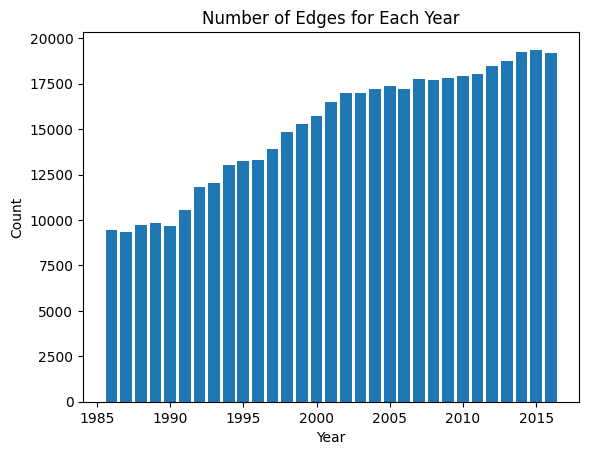

In [34]:
import torch
import matplotlib.pyplot as plt

# get the unique values and their counts
unique_values, counts = torch.unique(data.t, return_counts=True)

# create a bar plot
plt.bar(unique_values, counts)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Edges for Each Year')
plt.show()

## Split Dataset

In [19]:
train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15
)

batch_size = 200

train_loader = TemporalDataLoader(train_data, batch_size=batch_size)
val_loader = TemporalDataLoader(val_data, batch_size=batch_size)
test_loader = TemporalDataLoader(test_data, batch_size=batch_size)

## Prediction using Exponential Moving Average

The update function for node affinity predictions

### Explain the function total algorithm visually

In [40]:
def test_n_upate(loader):
    label_t = dataset.get_label_time()  # check when does the first label start
    num_label_ts = 0
    total_score = 0

    for batch in loader:
        query_t = batch.t[-1]
        if query_t > label_t:
            label_tuple = dataset.get_node_label(query_t)
            if label_tuple is None:
                break
            label_ts, label_srcs, labels = (
                label_tuple[0],
                label_tuple[1],
                label_tuple[2],
            )
            label_ts = label_ts.numpy()
            label_srcs = label_srcs.numpy()
            labels = labels.numpy()
            label_t = dataset.get_label_time()

            preds = []

            for i in range(0, label_srcs.shape[0]):
                node_id = label_srcs[i]
                pred_vec = forecaster.query_dict(node_id)
                preds.append(pred_vec)
                forecaster.update_dict(node_id, labels[i])

            np_pred = np.stack(preds, axis=0)
            np_true = labels

            input_dict = {
                'y_true': np_true,
                'y_pred': np_pred,
                'eval_metric': [eval_metric],
            }
            result_dict = evaluator.eval(input_dict)
            score = result_dict[eval_metric]

            total_score += score
            num_label_ts += 1

    metric_dict = {}
    metric_dict[eval_metric] = total_score / num_label_ts
    return metric_dict


## Explain ExponentialMovingAverage functionality

In [ ]:
class ExponentialMovingAverage:
    def __init__(self, num_class, alpha=0.1):
        self.dict = {}
        self.num_class = num_class
        self.alpha = alpha

    def update_dict(self, node_id, label):
        if node_id in self.dict:
            self.dict[node_id] = self.alpha * label + (1 - self.alpha) * self.dict[node_id]
        else:
            self.dict[node_id] = label

    def query_dict(self, node_id):
        r"""
        Parameters:
            node_id: the node to query
        Returns:
            returns the last seen label of the node if it exists, if not return zero vector
        """
        if node_id in self.dict:
            return self.dict[node_id]
        else:
            return np.zeros(self.num_class)

## Todo:
- Extract only 5 nodes/countries from the big graphs
- Visualize the updates using the plots for three (Line plot with three color)
    - Moving Average
    - Exponential Moving Average
    - Persistance
- Visalize the iteration on the graph nodes.
